# Introducción

**1 Introducción**

Antes de comenzar es conveniente resaltar algunos supuestos básicos para realizar pronósticos, estos supuestos se basan en el sentido común a la vez de fundamentos teóricos estadísticos.

- El pronóstico se realiza teniendo en cuenta que el mercado y las demás codiciones de mercado se mantienen estables, pues perturbaciones en estos provocarán cambios inesperados que no pudieron modelarse.
- Se acepta un cambio gradual, mas no, uno drástico.
- Eventos como ajustes el política monetaria de los Estados Unidos o cambios geopóliticos, son eventos que requieren una modelización detallada.

**2. Tipos de modelos**

A los modelos construidos se los clasificará dentro de Modelos de Series de Tiempo Univariadas y Multivariadas. Pueden existir muchas mas clasificaciones, pero considero que esta clasificación segun la dimensionalidad del problema representa de buena manera la complejidad que puede tener un modelo.

**3. Evaluación de modelos**

Dado que trabajaremos con datos continuos, es conveniente establecer una métrica que nos permita evaluar la predicción de nuestros modelos.

**3.1 Error Cuadrático Medio**

El Error Cuadrático Medio (MSE) es una de la métricas más utilizadas en el Machine Learning. Esta métrica se calcula como el promedio de los errores al cuadrado:
$$MSE = \frac{1}{n} ∑ \left(y_t - \hat{y}_t \right)^2$$

**3.2 Raiz del Error Cuadrático Medio**

La Raiz del Error Cuadrático Medio (RMSE), es la raiz del Error Cuadrático Medio. La ventaja de sacar esta métrica se debe al hecho de que la raiz cuadrada del MSE es que la escala del RMSE es la misma que la escala de la variable original.
$$RMSE = \sqrt{MSE}$$

**3.3 Error Absoluto Medio**

El Error Absoluto Medio (MAE), toma la diferencia absoluta de los valores reales y los valores pronosticados:
$$MAE = \frac{1}{n} \sum |y_t - \hat{y}_t|$$

**3.4 Error Porcentual Absoluto Medio**
En términos simples, el MAPE calcula el porcentaje promedio de error absoluto entre las predicciones y los valores reales. Cuanto menor sea el MAPE, mejor será la precisión del modelo de predicción. Sin embargo, el MAPE tiene la limitación de ser sensible a los casos en los que los valores reales son cercanos o iguales a cero. En tales casos, el MAPE puede volverse indefinido o infinitamente grande.
$$MAPE =  \frac{1}{n} \sum \left|\frac{y_t - \hat{y}_t}{y_t}\right|$$

**3.5 R2**

El coeficiente de determinación, comúnmente conocido como R2 (R cuadrado), es una métrica estadística que proporciona una medida de la calidad de un modelo de regresión en relación con los datos observados. Es una medida que indica cuánta variabilidad en la variable dependiente puede ser explicada por el modelo.
$$R^2 = 1 - \frac{\sum (y_t - \hat{y}_t)^2}{\sum (y_t - \bar{y}_t)^2}$$


# Pronóstico de Series de Tiempo


In [ ]:
pip install pmdarima

In [6]:
#Manipulacion y tratamiento de los datos
import numpy as np
import pandas as pd

#Visualizacion de datos
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

#Modelacion ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

#Modelacion Auto ARIMA
from pmdarima import auto_arima

#Métrica de evaluacion
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics

#Importar datos desde la API de Yahoo Finance
import yfinance as yf

#No presentar advertencias
import warnings
warnings.filterwarnings('ignore')

In [118]:
# Es conveniente crear una función para evaluar las métricas, para así no repetir código

def metric_evaluation(y_true, y_pred):
    def mean_absolute_percentaje_error(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        np.mean(np.abs((y_true - y_pred) / y_pred)) *100
        return
    print('Evaluation metric results:')
    print(f'MSE is: {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is: {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is: {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is: {mean_absolute_percentaje_error(y_true, y_pred)}')
    print(f'R2 is: {metrics.r2_score(y_true, y_pred)}', end='n/n')


In [21]:
#Importamos los datos de YF
GOOG = yf.download('GOOG', start = '2004-08-19', end = '2024-02-14')
GOOG.head(1)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216


In [83]:
# Usaremos solo la columna de precio de cierre
GOOG_Close = pd.DataFrame(GOOG["Close"])

In [84]:
#El indice esta correctamente en formato fecha
GOOG_Close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4905 entries, 2004-08-19 to 2024-02-13
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   4905 non-null   float64
dtypes: float64(1)
memory usage: 76.6 KB


In [85]:
#Gráfico
fig = px.line(GOOG_Close, x = GOOG_Close.index, y = 'Close', title = 'GOOGLE')
fig

# ARIMA


Para usar los modelos de tipo ARIMA necesitamos comprobar que los momentos incondicionales existen, o dicho de otra forma que la serie de tiempo es estacionaria. Observando el anterior gráfico, es posible intuir que el primer momento incondicional no existe, pues parece haber una tendencia.

Sin embargo, no podemos guiarnos por el ojo humnao, por ello lo usual es usar una bateria de test que nos indiquen si la serie presenta o no raices unitarias.

In [52]:
# Test Dickey Fuller
# Para ello crearemos una función para automatizar el rechazo o no de la Hipotesis Nula
# La Hipotesis Nula es que Existe una raiz unitaria
def augmented_dickey_fuller_test_func(series, column_name):
    print(f'Resultados de la Prueba ADF para la columna: {column_name}')
    dftest = adfuller(series, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Estatistic', 'P-value', 'No Lags Used', 'Número de observaciones usadas'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print('Conclusión:')
        print('Rechazar la Hipótesis Nula')
        print('Los datos son estacionarios')
    else:
        print('Conclusión:')
        print('No se Rechaza la Hipótesis Nula')
        print('Los datos no son estacionarios')

In [31]:
augmented_dickey_fuller_test_func(GOOG_Close['Close'], 'Close')

Resultados de la Prueba ADF para la columna: Close
Test Estatistic                      1.357598
P-value                              0.996913
No Lags Used                        31.000000
Número de observaciones usadas    4873.000000
Critical Value (1%)                 -3.431693
Critical Value (5%)                 -2.862133
Critical Value (10%)                -2.567086
dtype: float64
Conclusión:
No se Rechaza la Hipótesis Nula
Los datos no son estacionarios


In [34]:
#Como los datos son de frecuencia diaria, no hay necesidad de saber si tiene un componente estacional

#plt.rcParams['figure.figsize'] = (12,8)
#a = seasonal_decompose(GOOG_Close['Close'], model = 'add')
#a.plot()

Ejecutamos la función auto_arima() para obtener los valores (p,d,q)

In [35]:
auto_arima(GOOG_Close['Close'], start_p=0, start_q=0,
           max_=4, max_d=2, max_q=4, m=365, seasonal=False,
           error_action='warn', trace=True, supress_warnings=True,
           stepwise=True, random_state=20, n_filts=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14659.550, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14657.415, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14657.320, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14661.179, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14641.536, Time=7.48 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14643.480, Time=6.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14643.484, Time=6.90 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=14658.560, Time=1.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=14658.885, Time=1.39 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14644.996, Time=12.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=14645.569, Time=1.50 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 39.151 seconds


ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True)

El mejor modelo, basado en el criterio de información de Akaike (AIC), es una ARIMA(1,1,1) con intercepto.

## División de los datos en entrenamiento y prueba

In [43]:
#Dividimos el conjunto de datos en entrenamiento (80%) y prueba (20%)
GOOG_Close.shape

(4905, 1)

In [87]:
train_data = GOOG_Close[:3924]
test_data = GOOG_Close[3925:]

In [88]:
test_data

,Close
Date,
2020-03-24,56.723000
2020-03-25,55.124500
2020-03-26,58.087502
2020-03-27,55.535500
2020-03-30,57.341000
...,...
2024-02-07,146.679993
2024-02-08,147.220001
2024-02-09,150.220001


In [89]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 980 entries, 2020-03-24 to 2024-02-13
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   980 non-null    float64
dtypes: float64(1)
memory usage: 15.3 KB


In [90]:
#instanciamos la clase y utilzamos sus métodos
arima_model = SARIMAX(train_data['Close'], order = (1,1,1), trend = 'c')
arima_result = arima_model.fit()
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3924
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2921.680
Date:                Wed, 14 Feb 2024   AIC                           5851.361
Time:                        00:28:42   BIC                           5876.459
Sample:                             0   HQIC                          5860.266
                               - 3924                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0145      0.009      1.594      0.111      -0.003       0.032
ar.L1         -0.1065      0.064     -1.669      0.095      -0.231       0.019
ma.L1          0.0205      0.066      0.311      0.7

In [110]:
#Predicciones del modelo
arima_pred = arima_result.predict(start=len(train_data), end=len(GOOG_Close)-2, typ='levels').rename('ARIMA Predictions')
arima_pred

3924    53.816464
3925    53.809581
3926    53.824771
3927    53.837611
3928    53.850700
          ...    
4899    66.537583
4900    66.550649
4901    66.563715
4902    66.576781
4903    66.589846
Name: ARIMA Predictions, Length: 980, dtype: float64

In [112]:
# No tiene formato fecha, por que?
# Le asignamos nuevamente
fechas_arima_pred = pd.date_range(start='2020-03-24', periods=len(arima_pred), freq='B')

# Asignamos las fechas
arima_pred.index = fechas_arima_pred
arima_pred

2020-03-24    53.816464
2020-03-25    53.809581
2020-03-26    53.824771
2020-03-27    53.837611
2020-03-30    53.850700
                ...    
2023-12-19    66.537583
2023-12-20    66.550649
2023-12-21    66.563715
2023-12-22    66.576781
2023-12-25    66.589846
Freq: B, Name: ARIMA Predictions, Length: 980, dtype: float64

In [113]:
arima_pred.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 980 entries, 2020-03-24 to 2023-12-25
Freq: B
Series name: ARIMA Predictions
Non-Null Count  Dtype  
--------------  -----  
980 non-null    float64
dtypes: float64(1)
memory usage: 15.3 KB


Text(0.5, 1.0, 'Prediccion con el modelo ARIMA')

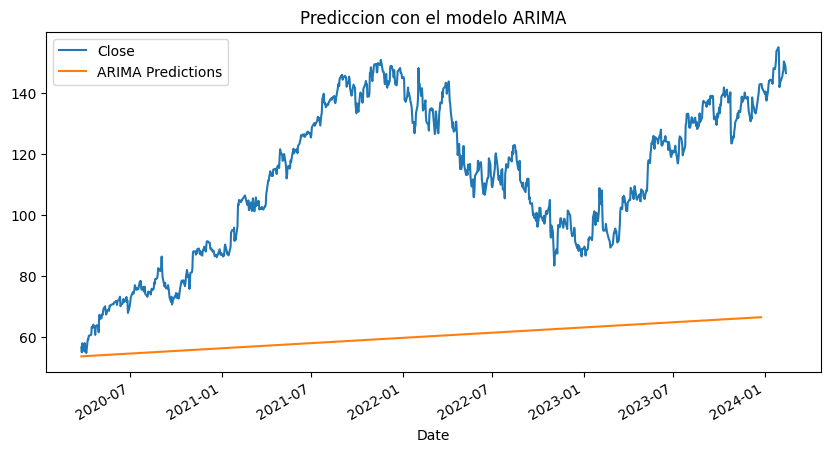

In [114]:
# Graficamos
test_data['Close'].plot(figsize = (10,5), legend=True)
arima_pred.plot(legend=True)
plt.title('Prediccion con el modelo ARIMA')

In [115]:
arima_pred

2020-03-24    53.816464
2020-03-25    53.809581
2020-03-26    53.824771
2020-03-27    53.837611
2020-03-30    53.850700
                ...    
2023-12-19    66.537583
2023-12-20    66.550649
2023-12-21    66.563715
2023-12-22    66.576781
2023-12-25    66.589846
Freq: B, Name: ARIMA Predictions, Length: 980, dtype: float64

In [116]:
test_data

,Close
Date,
2020-03-24,56.723000
2020-03-25,55.124500
2020-03-26,58.087502
2020-03-27,55.535500
2020-03-30,57.341000
...,...
2024-02-07,146.679993
2024-02-08,147.220001
2024-02-09,150.220001


In [119]:
# No dio lo que esperaba
# Evaluamos las metricas de prediccion
metric_evaluation(test_data, arima_pred)

Evaluation metric results:
MSE is: 3190.9671802487005
MAE is: 51.73865567186007
RMSE is: 56.48864647208942
MAPE is: None
R2 is: -4.291520064650697n/n

# LSTM

## Estandarización

In [121]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

Antes de crear el modelo LSTM, debemos crear un objeto Generador de series temporales